In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
import cv2

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [2]:
# load data
all_data= np.load(file="alldata_3D.npy")
all_lables=pd.read_csv('label.csv')
test_images=np.load(file='testdata_3D.npy')
test_lables=pd.read_csv('test_label.csv')

# create label multiclassification array 
labels=[]
test_labels=[]
for i in range(3000):
    data = all_lables['label'][i]
    if data == 'no_tumor':
        #label.append(data)
        labels.append(0)
    elif data == 'meningioma_tumor':
        #label.append('meningioma_tumor')
        labels.append(1)
    elif data == 'glioma_tumor':
        #label.append('glioma_tumor')
        labels.append(2)
    elif data == 'pituitary_tumor':
        #label.append('pituitary_tumor')
        labels.append(3)

for i in range(200):
    data = test_lables['label'][i]
    if data == 'no_tumor':
        #label.append(data)
        test_labels.append(0)
    elif data == 'meningioma_tumor':
        #label.append('meningioma_tumor')
        test_labels.append(1)
    elif data == 'glioma_tumor':
        #label.append('glioma_tumor')
        test_labels.append(2)
    elif data == 'pituitary_tumor':
        #label.append('pituitary_tumor')
        test_labels.append(3)
        
labels = np.array(labels)
test_labels =np.array(test_labels)

In [3]:
# Normalize the pixel value into a floating-point number between 0 and 1.
all_data = np.array(all_data, dtype="float") / 255.0 
test_images= np.array(test_images, dtype="float") / 255.0

# Direct adjustment of hyperparameter
INIT_LR = 0.00005
EPOCHS = 50
BS = 16

# Divided into training set and verification set according to 8: 2
train_images,val_images,train_labels,val_labels=train_test_split(all_data,labels,test_size=0.2,random_state=0)

In [4]:
#Data Augmentation
aug=train_image_generator = keras.preprocessing.image.ImageDataGenerator(
                                            horizontal_flip=True,
                                            fill_mode='nearest')
#validation_image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [5]:
#VGG16 Model
model = keras.models.Sequential()  
model.add(keras.layers.ZeroPadding2D((1,1), input_shape=(224,224,3)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

#model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

#model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
#model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
#model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

#model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu'))
#model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu'))
#model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

#model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu'))
#model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu'))
#model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4, activation='softmax'))
#sgd = keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True) #Random gradient descent
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 107, 107, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 128)       0

In [6]:
#complie and fit model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1,min_lr=0.01*INIT_LR)
history =model.fit(aug.flow(train_images, train_labels, batch_size=BS), epochs=EPOCHS,validation_data=(val_images, val_labels),callbacks=[reduce_lr])
#history =model.fit(train_images, train_labels, batch_size=16, epochs=20,validation_data=(val_images, val_labels))

Epoch 1/50
150/150 [==============================] - 34s 171ms/step - loss: 1.3741 - accuracy: 0.2754 - val_loss: 1.3690 - val_accuracy: 0.2767
Epoch 2/50
150/150 [==============================] - 15s 101ms/step - loss: 1.3615 - accuracy: 0.2825 - val_loss: 1.3635 - val_accuracy: 0.2950
Epoch 3/50
150/150 [==============================] - 16s 104ms/step - loss: 1.3103 - accuracy: 0.3142 - val_loss: 1.3119 - val_accuracy: 0.3067
Epoch 4/50
150/150 [==============================] - 16s 106ms/step - loss: 1.1426 - accuracy: 0.4888 - val_loss: 1.0276 - val_accuracy: 0.5417
Epoch 5/50
150/150 [==============================] - 16s 106ms/step - loss: 1.0089 - accuracy: 0.5558 - val_loss: 0.8974 - val_accuracy: 0.6100
Epoch 6/50
150/150 [==============================] - 15s 102ms/step - loss: 0.9031 - accuracy: 0.6175 - val_loss: 0.8758 - val_accuracy: 0.6100
Epoch 7/50
150/150 [==============================] - 15s 103ms/step - loss: 0.8354 - accuracy: 0.6467 - val_loss: 0.7699 - val_ac

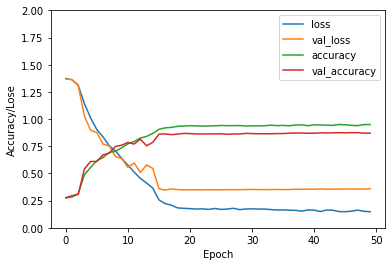

7/7 [==============================] - 0s 50ms/step - loss: 0.4393 - accuracy: 0.8500
0.8500000238418579 0.4393339157104492


In [8]:
#plot the curse and result
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Lose')
plt.ylim([0, 2])
plt.legend(loc='upper right')
plt.show()

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)
print(test_acc, test_loss)